In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import tensorflow as tf
import seaborn as sns
import pickle 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import *
from matplotlib.pyplot import figure

# from keras import backend as K



In [8]:
tf_config = K.tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
session = K.tf.Session(config=tf_config)
K.set_session(session)

In [9]:
df = pd.read_csv ('/data/Data/yntn/data_labeled.csv')

Text(0.5, 0, 'Label')

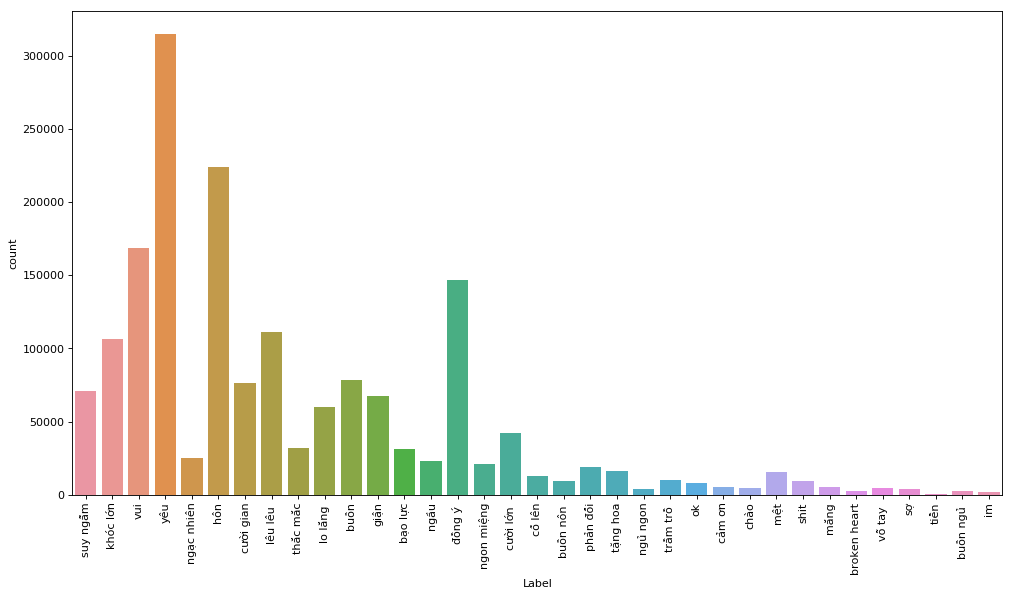

In [4]:
figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')
plt.xticks(rotation=90)
sns.countplot(df.label)
plt.xlabel('Label')

In [5]:
X = df.text
Y = df.label
le = LabelEncoder()
Y = le.fit_transform(Y)

In [6]:
onehot_Y = []

for i in range(len(Y)):
    tmp = []
    tmp = [ 0 for i in range(0, 35)] # set all 0
    tmp[Y[i]] = 1 
    onehot_Y.append(tmp)

In [7]:
Y = np.array(onehot_Y)

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2, random_state = 42)

In [9]:
max_words = 88860
max_len = 30
tok = Tokenizer(num_words = max_words)
X_train = [str(s) for s in X_train]
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [10]:
pickle.dump(tok, open('tokenize.pkl','wb'))

In [11]:
word_dict = pickle.load (open("/data/Data/yntn/word_embedding_vec.pkl",'rb'))

In [12]:
w = np.random.normal(0, 1, (max_words, 300))

In [13]:
for i in range (1, len(tok.index_word)):
    if (tok.index_word[i] in word_dict):
        w[i] = word_dict[tok.index_word[i]]

In [14]:
def RNN():
    inputs = Input(name = 'inputs', shape = [max_len])
    layer = Embedding(max_words, 300, input_length = max_len, weights = [w])(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name = 'FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(35,name = 'out_layer')(layer)
    layer = Activation('softmax')(layer)
    model = Model(inputs = inputs,outputs = layer)
    return model

In [15]:
model  = RNN()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 30)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 30, 300)           26658000  
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                93440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 35)                8995      
__________

In [18]:

# # Compatible with tensorflow backend

# # def focal_loss(gamma=10, alpha=.25):
# def focal_loss(gamma=10, alpha=.25):
#     def focal_loss_fixed(y_true, y_pred):
#         pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
#         pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
#         return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
#     return focal_loss_fixed

In [19]:
def focal_loss(gamma=10, alpha=4.):

    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

In [25]:
# model.compile(loss = 'categorical_crossentropy', optimizer = RMSprop(),metrics = ['accuracy'])

## focal loss
model.compile(loss=[focal_loss(alpha=.25, gamma=10)], metrics=["accuracy"], optimizer='adam')

In [26]:
weight_file = "model_LSTM_focal_loss_3.hdf5"
callbacks = [
    EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 1),
    ModelCheckpoint(weight_file, monitor = 'val_loss', verbose = 1, save_best_only = True)
]

In [27]:
history = model.fit(sequences_matrix,Y_train,batch_size = 512, epochs = 10,
          validation_split = 0.2, callbacks = callbacks)

Train on 1109777 samples, validate on 277445 samples
Epoch 1/10


ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[Node: Adam/beta_1/initial_value = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [] values: 0.9>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

Caused by op 'Adam/beta_1/initial_value', defined at:
  File "/data/Data/khoint3/miniconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/data/Data/khoint3/miniconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/data/Data/khoint3/miniconda3/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/data/Data/khoint3/miniconda3/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/data/Data/khoint3/miniconda3/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 781, in inner
    self.run()
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3220, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-25-36ac00ef3442>", line 4, in <module>
    model.compile(loss=[focal_loss(alpha=.25, gamma=10)], metrics=["accuracy"], optimizer='adam')
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/keras/engine/training.py", line 96, in compile
    self.optimizer = optimizers.get(optimizer)
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/keras/optimizers.py", line 796, in get
    return deserialize(config)
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/keras/optimizers.py", line 768, in deserialize
    printable_module_name='optimizer')
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/keras/utils/generic_utils.py", line 147, in deserialize_keras_object
    return cls.from_config(config['config'])
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/keras/optimizers.py", line 154, in from_config
    return cls(**config)
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/keras/optimizers.py", line 464, in __init__
    self.beta_1 = K.variable(beta_1, name='beta_1')
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 402, in variable
    v = tf.Variable(value, dtype=tf.as_dtype(dtype), name=name)
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 259, in __init__
    constraint=constraint)
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 380, in _init_from_args
    initial_value, name="initial_value", dtype=dtype)
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1011, in convert_to_tensor
    as_ref=False)
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1107, in internal_convert_to_tensor
    ret = conversion_func(value, dtype=dtype, name=name, as_ref=as_ref)
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/constant_op.py", line 217, in _constant_tensor_conversion_function
    return constant(v, dtype=dtype, name=name)
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/constant_op.py", line 202, in constant
    name=name).outputs[0]
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3414, in create_op
    op_def=op_def)
  File "/data/Data/khoint3/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1740, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor of shape [] and type float
	 [[Node: Adam/beta_1/initial_value = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [] values: 0.9>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]


In [33]:
X_test = [str(s) for s in X_test]
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)
accr = model.evaluate(test_sequences_matrix,Y_test)

346806/346806 [==============================] - 182s 524us/step


In [34]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.349
  Accuracy: 0.264
